In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option('display.max_colwidth', 0)
from datetime import datetime
import json
import nltk
import re
import numpy as np
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('dutch')

# Load data

In [2]:
file = spark.read.load('/user/rdekorte/NLP/test_data')
df_attrs = file.select('ad_id', 'L1name_adpost', 'L2name_adpost', 'attribute_desc', 'attribute_value_desc').toPandas()
df_text = file.select('ad_id', 'title', 'discription').drop_duplicates(['ad_id']).toPandas()
df_attrs_map = pd.read_excel('../../data/single-multi-attributes.xlsx')
df_attrs = df_attrs.rename(columns = {"L1name_adpost": 'l1',
                                      "L2name_adpost": "l2",
                                      "attribute_desc": 'attribute',
                                      "attribute_value_desc": 'value'
                                     })
df_attrs_map = df_attrs_map.rename(columns = {'attr_name_nl-NL': 'attribute',
                                              'attr_value_nl-NL': 'value',
                                              'L1_name': 'l1',
                                              'L2_name': 'l2'
                                             })
df_attrs_map = df_attrs_map[['l1', 'l2', 'attribute', 'value', 'attribute_type']].drop_duplicates()
df_text = df_text.set_index('ad_id').drop_duplicates()
df_attrs = df_attrs[df_attrs['ad_id'].isin(df_text.index)].set_index('ad_id')

# Distribution of length of title+description

Kinderen en Baby's
167813


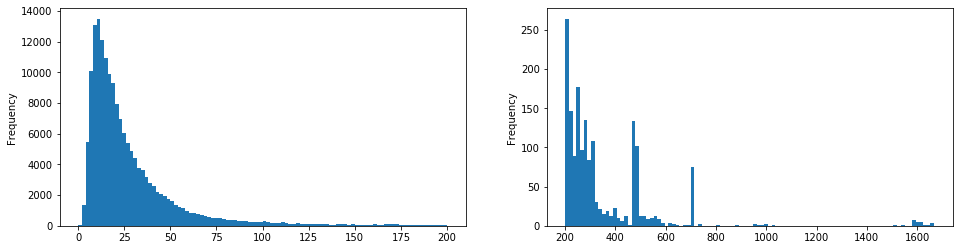

Huis en Inrichting
147900


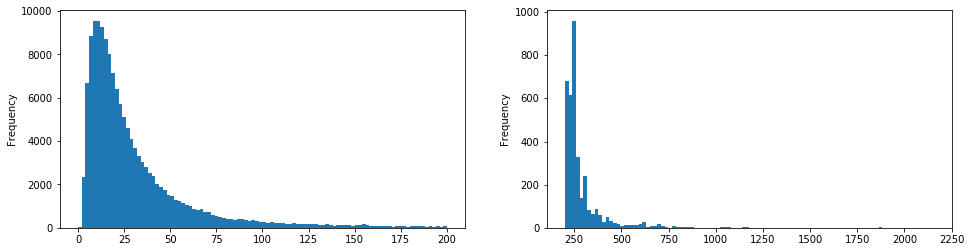

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
tokenizer = CountVectorizer().build_tokenizer()
def length(s):
    return len(tokenizer(s)) if s else 0
df_text['length'] = df_text['title'].apply(length) + df_text['discription'].apply(length)
for l1 in df_attrs['l1'].unique():
    print(l1)
    fig, axes = plt.subplots(1, 2, figsize = (16, 4))
    s = df_text[df_text.index.isin(df_attrs[df_attrs['l1'] == l1].index.unique())]['length']
    print(len(s))
    s[s<=200].plot(kind = 'hist', bins = 100, ax = axes[0])
    s[s>200].plot(kind = 'hist', bins = 100, ax = axes[1])
    plt.show()

# Coverage of attributes among L2s

In [4]:
#to-do 
#differentiate between sellers?
for l1 in df_attrs['l1'].unique():
    print(l1)
    df_map_l1 = df_attrs_map[df_attrs_map['l1'] == l1]
    print("#L2s", df_map_l1['l2'].nunique())
    attribute_coverage = df_map_l1.groupby('attribute')['l2'].nunique()/df_map_l1['l2'].nunique()
    display(pd.DataFrame(attribute_coverage.sort_values(ascending = False)).T)
good = df_attrs_map[ (df_attrs_map['attribute'] == 'Conditie') & (df_attrs_map['l1'] == 'Huis en Inrichting')]['l2'].unique()
print("Some L2s don't have conditie as a mandatory attribute:")
df_attrs_map[~df_attrs_map['l2'].isin(good) & (df_attrs_map['l1'] == 'Huis en Inrichting')]['l2'].unique()

Kinderen en Baby's
#L2s 83


attribute,Levering,Conditie,Type,Bestemd voor,Type kledingstuk,Eigenschappen,Merk,Maat,Lengte,Leeftijd vanaf,Breedte,Vorm,Diepte,Aantal stukjes,Bevestigingsmethode,Kleur,Draaggewicht,Hoogte,In breedte uitschuifbaar tot,Materiaal,Maximaal bereik,Soort,Aandrijving
l2,1.0,1.0,0.457831,0.421687,0.277108,0.204819,0.120482,0.060241,0.024096,0.024096,0.024096,0.012048,0.012048,0.012048,0.012048,0.012048,0.012048,0.012048,0.012048,0.012048,0.012048,0.012048,0.012048


Huis en Inrichting
#L2s 98


attribute,Levering,Conditie,Materiaal,Breedte,Hoogte,Type,Kleur,Diepte,Lengte,Vorm,Aantal personen,Eigenschappen,Uitvoering,Soort,Oppervlakte,Ruimte voor,Geschikt voor,Aantal stoelen,Aantal laden,Bestemd voor,Bloeiwijze,Brandstof,Lichtbehoefte,Stijl,Materiaal keukenblad,Extra's,Fitting,Vermogen (equivalent),Inhoud,Aantal
l2,1.0,0.959184,0.459184,0.336735,0.326531,0.285714,0.193878,0.163265,0.142857,0.132653,0.112245,0.112245,0.061224,0.030612,0.020408,0.020408,0.020408,0.020408,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204,0.010204


Some L2s don't have conditie as a mandatory attribute:


array(['Complete inboedels', 'Kamerplanten', 'Schoonmaakartikelen',
       'Stoffering | Behang'], dtype=object)

# Coverage of attributes among ads

In [5]:
df_attrs = df_attrs.dropna()
l1s = df_attrs['l1'].unique()
for l1 in l1s:
    print(l1)
    df_l1 = df_attrs[df_attrs['l1'] == l1]
    print("#ads", df_l1.index.nunique())
    display(pd.DataFrame(df_l1['attribute'].value_counts()/df_l1.index.nunique()).T)

Kinderen en Baby's
#ads 167813


,Levering,Conditie,Bestemd voor,Merk,Type kledingstuk,Type,Eigenschappen,Maat,Bevestigingsmethode,Lengte,Breedte,Draaggewicht,Leeftijd vanaf,Vorm,Aantal stukjes,Soort,Kleur,Hoogte,Diepte,Aandrijving,Materiaal,In breedte uitschuifbaar tot,Maximaal bereik,79850,62745,Kinderen en Baby's,Conditie Postzegels,2040517,Levering Postzegels,Merk Sportcamera's,420,62868,Type Wintersportkleding Dames,47882,204,Type oven-grill,Bestemd voor Roleplaying,43028,48000,421,45287
attribute,0.999928,0.890295,0.346523,0.291664,0.285717,0.23463,0.042637,0.041695,0.008414,0.007699,0.005733,0.005691,0.005,0.003331,0.003319,0.002747,0.00267,0.002068,0.00199,0.00152,0.000888,0.00062,0.000512,0.000048,0.000042,0.000024,0.000018,0.000018,0.000018,0.000012,0.000012,0.000012,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006


Huis en Inrichting
#ads 147898


,Levering,Conditie,Materiaal,Breedte,Type,Hoogte,Kleur,Vorm,Lengte,Diepte,Aantal personen,Aantal stoelen,Uitvoering,Stijl,Soort,Eigenschappen,Brandstof,Aantal laden,Aantal,Lichtbehoefte,Materiaal keukenblad,Oppervlakte,Extra's,Geschikt voor,Ruimte voor,Inhoud,Fitting,Vermogen (equivalent),Bestemd voor,Volume,79850,62745,335,420,50836,Conditie Postzegels,Levering Postzegels,43053,Hoogte Rugtassen,Type oven-grill,Breedte Kinderbedden,75796,438,47882,62916
attribute,0.999838,0.842912,0.259828,0.150793,0.146547,0.122436,0.105383,0.087236,0.0666,0.065194,0.062164,0.032374,0.023029,0.021244,0.013617,0.012258,0.006606,0.005443,0.003259,0.003056,0.002596,0.002542,0.002049,0.001325,0.001318,0.001291,0.000798,0.000764,0.000602,0.000412,0.000142,0.000115,0.000054,0.000034,0.000027,0.00002,0.00002,0.00002,0.000014,0.000014,0.000014,0.000014,0.000007,0.000007,0.000007


# Attribute filling rate

In [6]:
for l1 in l1s:
    df_l1 = df_attrs[df_attrs['l1'] == l1]
    attr_filled = df_l1['attribute'].value_counts()
    attrs_l2 = df_attrs_map[df_attrs_map['l1'] == l1][['attribute', 'l2']].drop_duplicates()
    attr_ads = attrs_l2.merge(df_l1['l2'].reset_index().drop_duplicates(), on = 'l2', how = 'right')
    attr_all = attr_ads['attribute'].value_counts()
    fill_rate = attr_filled/attr_all
    fill_rate = fill_rate.dropna().sort_values(ascending = False)
    display(pd.DataFrame(fill_rate).T)

,Maat,Merk,Levering,Conditie,Type kledingstuk,Bestemd voor,Type,Kleur,Bevestigingsmethode,Soort,Materiaal,Aantal stukjes,Vorm,Aandrijving,Breedte,Lengte,Draaggewicht,Maximaal bereik,Hoogte,In breedte uitschuifbaar tot,Diepte,Eigenschappen,Leeftijd vanaf
attribute,3.891546,2.300804,0.999928,0.890295,0.669567,0.63209,0.547683,0.465213,0.463407,0.414568,0.392105,0.387344,0.383665,0.356145,0.322494,0.320357,0.313423,0.307143,0.274525,0.273684,0.264241,0.261637,0.260802


,Levering,Conditie,Type,Materiaal keukenblad,Aantal stoelen,Brandstof,Kleur,Aantal personen,Vorm,Stijl,Materiaal,Lengte,Bestemd voor,Inhoud,Aantal,Breedte,Aantal laden,Soort,Uitvoering,Hoogte,Ruimte voor,Diepte,Fitting,Vermogen (equivalent),Lichtbehoefte,Oppervlakte,Eigenschappen,Geschikt voor,Extra's
attribute,0.999838,0.865026,0.557832,0.521031,0.513018,0.498979,0.462122,0.453666,0.442941,0.428532,0.424647,0.3994,0.385281,0.385081,0.383453,0.376399,0.368759,0.361905,0.358526,0.338467,0.330508,0.327781,0.30102,0.288265,0.194075,0.173033,0.155024,0.141007,0.130099


# Attribute mapping table is incomplete

In [7]:
for attr in ['Merk', 'Maat']:
    print(attr)
    merk_l2s = df_attrs_map[df_attrs_map['attribute'] == attr]['l2'].unique()
    for l1 in l1s:
        print(l1)
        df_l1 = df_attrs[df_attrs['l1'] == l1]
        for attr in ['Merk', 'Maat']:
            print(df_l1[ (df_l1['attribute'] == attr) & (~df_l1['l2'].isin(merk_l2s))]['l2'].unique())

Merk
Kinderen en Baby's
['Babykleding | Maat 74' 'Kinderkleding | Schoenen en Sokken'
 'Kinderkleding | Maat 164' 'Kinderkleding | Maat 116'
 'Kinderkleding | Maat 140' 'Babykleding | Maat 62'
 'Kinderkleding | Maat 98' 'Kinderkleding | Maat 92'
 'Babykleding | Maat 68' 'Kinderkleding | Maat 134'
 'Kinderkleding | Maat 158' 'Kinderkleding | Maat 122'
 'Babykleding | Maat 56' 'Babykleding | Maat 86'
 'Kinderkleding | Maat 152' 'Babykleding | Maat 80'
 'Kinderkleding | Maat 128' 'Kinderkleding | Maat 176'
 'Kinderkleding | Maat 146' 'Babykleding | Schoentjes en Sokjes'
 'Kinderkleding | Mutsen, Sjaals en Handschoenen'
 'Kinderkleding | Maat 170' 'Babykleding | Overige'
 'Kinderkleding | Maat 110' 'Babykleding | Mutsen, Sjaals en Wanten'
 'Kinderkleding | Maat 104' 'Babykleding | Maat 50'
 'Kinderkleding | Overige' 'Babykleding | Petten en Hoeden'
 'Babykleding | Prematuur' 'Kinderkleding | Petten en Hoeden']
['Kinderkleding | Schoenen en Sokken' 'Speelgoed | Buiten | Skates'
 'Carnavalsk

# From now on selecting Huis en Inrichting only

In [15]:
l1 = 'Huis en Inrichting'
df_l1 = df_attrs[df_attrs['l1'] == l1]
df_text_l1 = df_text[df_text.index.isin(df_l1)]
df_attrs_map_l1 = df_attrs_map[df_attrs_map['l1'] == l1]

# Attribute value counts 

In [17]:
attrs = ['Conditie', 'Materiaal', 'Breedte', 'Type', 'Hoogte', 'Kleur', 'Vorm', 'Lengte', 'Diepte', 'Aantal personen', 'Aantal stoelen']
attr_counts = df_l1.groupby('ad_id').size().rename('n_attrs')
df_l1 = df_l1.join(attr_counts)
df_l1 = df_l1.join(df_text['length'])
for attr in attrs:
    print(attr)
    display(pd.DataFrame(df_l1[df_l1['attribute'] == attr]['value'].value_counts()).T)

Conditie


,Zo goed als nieuw,Gebruikt,Nieuw
value,58729,46010,19926


Materiaal


,Hout,Stof,Metaal,Overige materialen,Leer,Glas,Overige houtsoorten,Eikenhout,Kunststof,Glas|Metaal,Aardewerk,Teakhout,Porselein,Hout|Stof,Grenenhout,Metaal|Stof,Aardewerk of Porselein,Kunststof|Metaal,Leer|Metaal,Riet of Rotan,Riet,Metaal of Aluminium,Hout|Metaal,Rvs,Hout|Leer,Kersenhout,Overige houtsoorten|Metaal,Keramiek,Overige houtsoorten|Glas,Metaal|Overige materialen,Leer|Stof,Rvs of Chroom,Overige houtsoorten|Overige materialen,Eikenhout|Metaal,Eikenhout|Glas,Hout|Riet of Rotan,Gietijzer,Hout|Kunststof,Stof|Overige materialen,Glas|Overige materialen,Zilver,Hout|Overige materialen,Steigerhout,Steen,Kunststof|Stof,Grenenhout|Glas,Glas|Kunststof,Glas|Kunststof|Metaal,Glas|Metaal|Overige materialen,Hout|Stof|Overige materialen,Kunststof|Metaal|Overige materialen,Hout|Metaal|Stof,Eikenhout|Overige houtsoorten,Leer|Overige materialen,Kunststof|Metaal|Stof,Kunststof|Overige materialen,Teakhout|Metaal,Steen of Aardewerk,Aluminium,Glas|Hout,Porselein of Keramiek,Eikenhout|Grenenhout|Kersenhout|Teakhout|Overige houtsoorten|Overige materialen,Teakhout|Glas,Overige houtsoorten|Kunststof,Hout|Leer|Metaal,Glas|Hout|Metaal,Metaal|Stof|Overige materialen,Hout|Kunststof|Metaal,Kersenhout|Glas,Overige houtsoorten|Glas|Metaal,Eikenhout|Overige materialen,Goud,Brons of Koper,Kunststof|Leer,Hout|Leer|Stof,Grenenhout|Overige houtsoorten,Kunststof|Leer|Metaal,Leer|Metaal|Stof,Hout|Leer|Overige materialen,Glas|Kunststof|Metaal|Overige materialen,Hout|Metaal|Stof|Overige materialen,Teakhout|Overige houtsoorten,Hout|Metaal|Overige materialen,Hout|Kunststof|Stof,Riet of Rotan|Stof,Overige houtsoorten|Kunststof|Metaal,Overige houtsoorten|Glas|Overige materialen,Grenenhout|Metaal,Overige houtsoorten|Metaal|Overige materialen,Hout|Riet of Rotan|Stof,Hout|Leer|Metaal|Overige materialen,Metaal|Riet of Rotan,Hout|Kunststof|Leer,Grenenhout|Overige materialen,Glas|Hout|Kunststof|Metaal|Stof|Overige materialen,Leer|Metaal|Overige materialen,Overige houtsoorten|Kunststof|Overige materialen,Eikenhout|Grenenhout,Eikenhout|Grenenhout|Kersenhout|Teakhout|Overige houtsoorten|Glas|Kunststof|Metaal|Overige materialen,Hout|Kunststof|Metaal|Overige materialen,Hout|Kunststof|Overige materialen,Overige houtsoorten|Glas|Kunststof|Metaal,Kunststof|Metaal|Stof|Overige materialen,Eikenhout|Grenenhout|Kersenhout|Teakhout|Overige houtsoorten,Eikenhout|Teakhout,Kersenhout|Metaal,Eikenhout|Overige houtsoorten|Metaal,Glas|Metaal|Stof,Teakhout|Overige materialen,Hout|Leer|Metaal|Stof,Glas|Kunststof|Overige materialen,Hout|Metaal|Riet of Rotan,Teakhout|Overige houtsoorten|Metaal,Kunststof|Stof|Overige materialen,Eikenhout|Grenenhout|Kersenhout|Teakhout|Overige houtsoorten|Metaal|Overige materialen,Eikenhout|Metaal|Overige materialen,Leer|Riet of Rotan,Hout|Kunststof|Stof|Overige materialen,Overige houtsoorten|Kunststof|Metaal|Overige materialen,Glas|Hout|Overige materialen,Teakhout|Overige houtsoorten|Overige materialen,Hout|Kunststof|Metaal|Stof,Hout|Kunststof|Leer|Metaal|Riet of Rotan|Stof|Overige materialen,Leer|Stof|Overige materialen,Kersenhout|Overige houtsoorten,Glas|Hout|Kunststof,Eikenhout|Grenenhout|Teakhout|Overige houtsoorten,Eikenhout|Overige houtsoorten|Glas,Metaal|Riet,Kunststof|Leer|Stof,Glas|Hout|Metaal|Overige materialen,Leer|Metaal|Stof|Overige materialen,Hout|Riet,Kersenhout|Overige materialen,Glas|Hout|Kunststof|Metaal,Grenenhout|Overige houtsoorten|Metaal,Hout|Kunststof|Leer|Metaal|Stof|Overige materialen,Kunststof|Leer|Metaal|Stof,Teakhout|Glas|Metaal,Hout|Kunststof|Leer|Metaal,Eikenhout|Kersenhout|Overige houtsoorten,Overige houtsoorten|Glas|Metaal|Overige materialen,Eikenhout|Glas|Metaal,Glas|Hout|Metaal|Stof,Eikenhout|Teakhout|Overige houtsoorten|Metaal|Overige materialen,Eikenhout|Kunststof,Eikenhout|Overige houtsoorten|Overige materialen,Grenenhout|Overige houtsoorten|Glas,Eikenhout|Glas|Overige materialen,Glas|Stof,Hout|Kunststof|Metaal|Stof|Overige materialen,Eikenhout|Teakhout|Overige houtsoorten,Eikenhout|Grenenhout|Overige houtsoorten,Hout|Leer|

Breedte


,50 tot 100 cm,100 tot 150 cm,150 tot 200 cm,Minder dan 50 cm,50 tot 75 cm,200 cm of meer,90 cm,200 tot 250 cm,75 tot 100 cm,140 cm,160 cm,Minder dan 150 cm,180 cm,250 tot 300 cm,80 cm,100 tot 125 cm,125 cm of meer,300 cm of meer,Minder dan 45 cm,45 tot 65 cm,100 cm,120 cm,Overige maten,70 cm of minder,70 tot 120 cm,65 cm of meer,120 tot 170 cm,Minder dan 70 cm,170 cm of meer
value,5173,2832,2611,1815,1474,1210,1142,881,874,575,524,467,456,412,370,280,225,196,142,133,114,110,107,92,52,14,10,9,2


Type


,Overige typen,Schilderij,Bureaustoel,Kandelaar,Kachel,Bureau zonder stoel,Echte plant,Matras,Bord(en),Kop(pen) en/of Schotel(s),Wandklok,Schaal,Mand,Schaal of Schalen,Laminaat,Met lade(s)|Met deur(en)|Met plank(en),Wandkapstok,Dekbedovertrek,Bedbodem,Wandbord,Kaars,Compleet servies,Kom(men),Glas of Glazen,Met plank(en),Zitzak,Met deur(en)|Met plank(en),Plafondspot of Wandspot,Open haard,Los bestek,Hoekkeuken,Met deur(en)|Met plank(en)|Met hangruimte,Deken of Dekbed,Foto of Poster,Print,Hoogslaper,Bureau met stoel,Pannenset,Bestekset,Met lade(s)|Met deur(en)|Met plank(en)|Met hangruimte,Kunstplant,Met deur(en),Met lade(s)|Met deur(en),Staande kapstok,Parket,Kussen,Enkelwandige keuken,Wasbak of Wastafel,Met lade(s),Kookpan of Snelkookpan,Led-lamp,Koekenpan of Braadpan,Stapelbed,Spiegelkast,Handdoek,Brandkast,Wastafelkast,Met lade(s)|Met plank(en),Staande klok,Letterbak,Wekker of Tafelklok,Schoonmaakmiddel,"Pot, Bus of Blik",Met lade(s)|Met deur(en)|Met klep(pen)|Met plank(en)|Met hangruimte,Krijtbord,(Half)hoge kast,Wok,Bak of Kom,Handdoekenrek,Bus of Trommel,Tafelkleed of Tafelzeil,Met plank(en)|Met hangruimte,Magneetbord,Tekening,Met lade(s)|Met deur(en)|Met klep(pen)|Met plank(en),Wandhaken,Tapijttegels,Tapijt,Schort,U-keuken,Brandblusser,Hoeslaken of Sloop,Mop of Dweil,Gloeilamp,Beker of Kan,Raamwisser of Trekker,Met lade(s)|Met plank(en)|Met hangruimte,Dubbelwandige keuken,Badmat,Placemat,Vinyl,Kinderkapstok,Halfhoogslaper,"Dweilemmer, -bak, of -wagen",Met hangruimte,Prikbord,Met deur(en)|Met klep(pen)|Met plank(en),Spaarlamp,Solo-systeem,Halogeen (gloei)lamp,Theedoek of Handdoek,Met lade(s)|Met klep(pen),Met lade(s)|Met deur(en)|Met hangruimte,Duo-systeem,Met klep(pen),Met lade(s)|Met deur(en)|Met klep(pen),Vloerspot of Grondspot,Met deur(en)|Met hangruimte,Gastendoekje,Bezem of Borstel,Zitzakstoel,Met deur(en)|Met klep(pen),Met lade(s)|Met hangruimte,Met klep(pen)|Met plank(en),Met lade(s)|Met klep(pen)|Met plank(en),Met lade(s)|Met klep(pen)|Met plank(en)|Met hangruimte,Met deur(en)|Met klep(pen)|Met plank(en)|Met hangruimte
value,2208,1287,1209,1008,936,904,812,809,782,604,592,574,549,442,437,372,369,359,263,260,248,239,233,229,205,204,204,197,191,188,182,174,170,168,168,159,150,145,144,138,126,108,107,100,99,98,94,94,93,91,90,86,83,79,78,78,63,60,59,59,58,55,53,53,52,51,51,48,48,48,47,46,46,45,37,34,33,32,32,32,31,30,30,29,28,27,26,25,25,22,22,21,18,15,14,13,12,10,10,9,9,9,9,9,8,8,7,6,6,5,5,5,5,3,2,2,1


Hoogte


,Minder dan 50 cm,Minder dan 100 cm,150 tot 200 cm,50 tot 75 cm,200 cm of meer,100 tot 150 cm,75 cm of meer,Minder dan 25 cm,25 tot 50 cm,45 tot 60 cm,60 tot 90 cm,Minder dan 45 cm,60 cm of meer,Minder dan 55 cm,55 tot 70 cm,30 tot 60 cm,90 cm of meer,70 cm of meer,120 tot 170 cm,160 tot 180 cm,Minder dan 160 cm,180 tot 200 cm,70 tot 120 cm,50 cm of meer,170 cm of meer,Minder dan 30 cm,Minder dan 70 cm,200 cm of hoger
value,3973,3384,2502,1850,1646,1243,1105,506,356,321,223,187,141,123,121,113,76,50,37,34,28,25,19,18,14,5,4,4


Kleur


,Wit,Overige kleuren,Bruin,Zwart,Grijs,Blauw,Rood,Beige,Groen,Crème,Roze,Geel,Oranje,Wit|Crème,Zwart|Wit,Zwart|Grijs,Wit|Grijs,Beige|Bruin|Wit|Grijs|Crème,Paars,Beige|Crème,Bruin|Grijs,Beige|Bruin,Blauw|Wit,Beige|Bruin|Crème,Blauw|Groen|Zwart|Overige kleuren|Rood|Beige|Bruin|Wit|Grijs|Crème,Overige kleuren|Bruin|Wit|Crème,Blauw|Groen,Beige|Bruin|Grijs|Crème,Blauw|Grijs,Overige kleuren|Wit,Bruin|Wit,Overige kleuren|Bruin|Wit,Zwart|Wit|Grijs,Grijs|Crème,Blauw|Groen|Overige kleuren|Rood|Crème,Zwart|Overige kleuren,Overige kleuren|Grijs,Overige kleuren|Bruin,Beige|Grijs,Groen|Grijs,Blauw|Overige kleuren,Bruin|Crème,Overige kleuren|Rood,Beige|Bruin|Wit|Crème,Zwart|Bruin,Rood|Wit,Zwart|Overige kleuren|Bruin|Wit,Groen|Overige kleuren|Beige|Bruin|Wit|Grijs|Crème,Beige|Wit,Groen|Overige kleuren,Overige kleuren|Bruin|Wit|Grijs|Crème,Beige|Wit|Crème,Zwart|Beige|Bruin|Grijs,Blauw|Beige,Beige|Wit|Grijs,Bruin|Wit|Grijs|Crème,Zwart|Bruin|Grijs|Crème,Overige kleuren|Bruin|Wit|Grijs,Overige kleuren|Bruin|Grijs,Overige kleuren|Beige|Crème,Blauw|Crème,Beige|Wit|Grijs|Crème,Zwart|Overige kleuren|Grijs,Overige kleuren|Crème,Beige|Bruin|Grijs,Overige kleuren|Wit|Crème,Overige kleuren|Beige|Bruin|Wit,Overige kleuren|Beige|Bruin|Crème,Blauw|Groen|Overige kleuren|Rood|Beige|Bruin|Crème,Blauw|Groen|Overige kleuren,Blauw|Rood|Wit,Zwart|Overige kleuren|Bruin,Bruin|Wit|Grijs,Zwart|Overige kleuren|Bruin|Wit|Grijs|Crème,Zwart|Bruin|Wit|Grijs|Crème,Wit|Geel,Blauw|Overige kleuren|Rood|Beige|Crème,Zwart|Overige kleuren|Bruin|Wit|Crème,Overige kleuren|Beige|Bruin,Oranje|Geel,Blauw|Overige kleuren|Rood|Beige|Grijs|Crème,Zwart|Bruin|Grijs,Blauw|Wit|Grijs,Zwart|Overige kleuren|Bruin|Crème,Overige kleuren|Beige|Bruin|Wit|Grijs,Zwart|Beige,Wit|Grijs|Crème,Blauw|Oranje|Wit|Geel|Crème,Groen|Wit,Zwart|Beige|Bruin|Wit|Grijs,Zwart|Beige|Wit|Grijs,Blauw|Groen|Overige kleuren|Rood|Grijs|Crème,Zwart|Beige|Bruin|Grijs|Crème,Zwart|Overige kleuren|Beige|Bruin|Wit|Grijs|Crème,Blauw|Rood|Beige|Crème,Zwart|Beige|Bruin|Wit|Grijs|Crème,Blauw|Rood,Overige kleuren|Beige|Bruin|Wit|Grijs|Crème,Blauw|Rood|Beige,Groen|Overige kleuren|Wit,Groen|Zwart|Wit,Blauw|Groen|Zwart|Overige kleuren|Rood|Beige|Wit|Crème,Zwart|Crème,Overige kleuren|Bruin|Crème,Zwart|Overige kleuren|Wit,Blauw|Groen|Rood|Beige|Bruin|Wit,Oranje|Wit,Roze|Wit,Zwart|Wit|Crème,Beige|Bruin|Wit,Zwart|Overige kleuren|Beige|Bruin|Wit|Grijs,Overige kleuren|Beige|Bruin|Wit|Crème,Groen|Oranje,Blauw|Groen|Overige kleuren|Beige|Bruin|Grijs|Crème,Zwart|Overige kleuren|Wit|Grijs,Blauw|Zwart|Overige kleuren,Blauw|Zwart,Blauw|Groen|Overige kleuren|Rood|Beige|Crème,Zwart|Beige|Bruin|Crème,Zwart|Bruin|Wit|Crème,Blauw|Beige|Bruin,Overige kleuren|Wit|Grijs,Overige kleuren|Beige|Bruin|Grijs|Crème,Blauw|Rood|Bruin,Groen|Overige kleuren|Beige|Bruin|Crème,Zwart|Beige|Wit|Crème,Zwart|Bruin|Wit|Grijs,Zwart|Beige|Bruin|Wit|Crème,Groen|Bruin,Blauw|Overige kleuren|Rood,Zwart|Overige kleuren|Beige|Bruin,Rood|Bruin,Zwart|Overige kleuren|Beige|Bruin|Wit,Groen|Crème,Blauw|Overige kleuren|Rood|Wit,Overige kleuren|Wit|Grijs|Crème,Blauw|Groen|Rood,Blauw|Groen|Geel,Blauw|Geel,Zwart|Overige kleuren|Beige|Crème,Blauw|Rood|Crème,Zwart|Beige|Grijs,Blauw|Groen|Zwart|Oranje|Beige|Bruin|Wit|Grijs|Geel,Zwart|Overige kleuren|Bruin|Wit|Grijs,Zwart|Rood|Bruin|Crème,Blauw|Overige kleuren|Rood|Grijs|Crème,Blauw|Paars,Overige kleuren|Rood|Beige|Bruin|Crème,Beige|Bruin|Wit|Grijs,Overige kleuren|Beige|Bruin|Grijs,Blauw|Bruin|Grijs,Zwart|Bruin|Wit,Zwart|Overige kleuren|Beige,Blauw|Groen|Overige kleuren|Rood|Bruin|Crème,Blauw|Overige kleuren|Rood|Bruin|Crème,Zwart|Rood|Wit,Blauw|Bruin,Overige kleuren|Beige,Blauw|Groen|Zwart|Oranje|Roze|Rood|Beige|Bruin|Wit|Grijs|Geel|Paars,Overige kleuren|Rood|Beige|Bruin,Bruin|Wit|Crème,Rood|Beige,Rood|Crème,Zwart|Wit|Geel,Oranje|Paars,Blauw|Rood|Beige|Bruin|Crème,Blauw|Groen|Overige kleuren|Bruin|Grijs|Crème,Zwart|Rood|Beige,Groen|Rood,Groen|Beige|Crème,Blauw|Overige kleuren|Crème,Zwart|Beige|Bruin,Zwart|Overige kleuren|Rood|Crème,Zwart|Ove

Vorm


,Rechthoekig,Rechte bank,Vierkant,Rond,Hoekbank,Overige vormen,Ovaal,Cilindervormig,Hartvormig
value,5043,2040,1800,1763,1289,506,452,5,4


Lengte


,200 cm,100 tot 150 cm,200 cm of meer,150 tot 200 cm,50 tot 100 cm,210 cm,Minder dan 55 cm,Minder dan 50 cm,190 cm of minder,55 tot 75 cm,220 cm,50 tot 75 cm,75 cm of meer,Overige maten,75 tot 100 cm,125 cm of meer,100 tot 125 cm
value,2820,1580,1287,1271,1177,294,289,278,203,182,115,85,84,83,55,28,19


Diepte


,25 tot 50 cm,75 tot 100 cm,50 tot 75 cm,Minder dan 75 cm,Minder dan 25 cm,100 tot 125 cm,150 cm of meer,75 cm of meer,40 tot 80 cm,125 tot 150 cm,Minder dan 40 cm,80 cm of meer
value,3800,2065,1904,901,301,210,197,131,68,61,3,1


Aantal personen


,Tweepersoons,Eenpersoons,Vijf personen of meer,Driepersoons,Vierpersoons of meer,Vier personen,Twijfelaar,Overige maten,tot twee personen,Drie personen
value,2798,2028,1326,1090,741,638,317,208,33,15


Aantal stoelen


,Vier,"Vijf, Zes of meer stoelen",Eén,Twee,Drie,4 tot 6 stoelen,6 tot 8 stoelen,Minder dan 4 stoelen
value,1240,1170,1093,938,185,129,23,10


# number of attributes/length of title+description

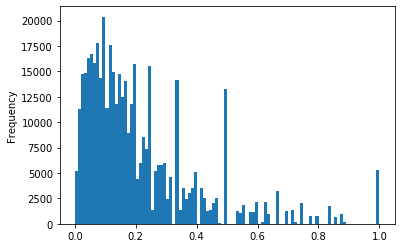

In [18]:
attrs_ratio = df_l1['n_attrs']/df_l1['length']
attrs_ratio[attrs_ratio <= 1].plot(kind = 'hist', bins = 100)
plt.show()

# Some stats of one attribute

In [19]:
'Materiaal', 'Type', 'Kleur', 'Vorm', 'Lengte', 'Breedte', 'Type', 'Hoogte'
tokenizer = CountVectorizer().build_tokenizer()
attr = 'Type'
ad_ids = df_l1[df_l1['l2'].isin(df_attrs_map[df_attrs_map['attribute'] == attr]['l2'].unique())].index.unique()
df_text_temp = df_text[df_text.index.isin(ad_ids)].drop(['length'], axis = 1)[['title', 'discription']]
df_l1_temp = df_l1[df_l1['attribute'] == attr][['attribute', 'value', 'l2']]
df_temp = df_text_temp.join(df_l1_temp, how = 'left')
def value_in(row):
    if pd.isnull(row['value']):
        return False
    values = row['value'].lower().strip().split('|')
    text = tokenizer(row['discription'].lower() +' '+ row['title'].lower())
    return len(set(values) & set(text)) > 0
print(attr)
print("#ads", df_temp.shape[0])
print("%filled", df_temp['value'].isna().sum()/df_temp.shape[0])
df_temp['annotate'] = df_temp.apply(value_in, axis=1)
print("% with exact matching of filled value and text", df_temp['annotate'].mean())
#print("% with exact matching of a value but no filled value", len(df_temp[ (df_temp['annotate'] == True) & df_temp['value'].isna()]))
df_temp.sample(10).sort_values('annotate', ascending = False)

Type
#ads 38854
%filled 0.4861018170587327
% with exact matching of filled value and text 0.19843516755031657


,title,discription,attribute,value,l2,annotate
ad_id,,,,,,
1603881237,Emma matras 35% kortingscode,Emma matras 35% korting code,Type,Matras,Slaapkamer | Matrassen en Bedbodems,True
1603658556,Fatboy zitzak groot formaat ORIGINEEL!,Mooie kleur ! \n\n\n180 x 140 cm\n\nAls nieuw.,Type,Zitzak,Zitzakken,True
1603467623,Atelier opruiming prachtig schilderij,"Prachtig handgeschilderd oplage 1. Op linnen met acrylverf. 1.00/1.20 cm. Ingelijst , met goed ophangsysteem . Atelier opruiming🖼. nu te koop aangeboden voor slechts €250.-🤩",Type,Schilderij,"Woonaccessoires | Schilderijen, Tekeningen en Foto's",True
1603200525,Bent U opzoek naar een houten vloer met een rustieke Uitstra,"**Bent U opzoek naar een houten vloer met een rustieke Uitstraling maar ondertussen met een lichte tint? Dan is dit de vloer voor U!**\r\nOnze vloer met de weissgrund tint is goed te combineren in zowel de landelijke en industriële stijl dit komt doordat de vloer erg naturel lijkt maar ondertussen beschikt over een lichte gloed! Dit houd dus in dat hij vrijwel met alles te combineren is! Deze prachtige vloer is ook Uitgerust met opvallende nerven en knoesten voor de liefhebber! Natuurlijk kunt U deze vloer ook verkrijgen met minder knoesten en minder opvallende nerven!\r\nWat vind U van deze vloer? Deze prachtige houten vloer is verkrijgbaar bij ons in de webshop samen met vele andere vloeren tegen de laagste prijs van Nederland!\r\n**U kunt via de website gratis U proefpakketje aanvragen!**\r\nHet goedkoopste online adres voor al U vloeren!!!\r\nVandaag een vloer voor 13:00 Uur besteld? De volgende werkdag gratis bezorgd aan huis.\r\n**Contact**\r\nVanaf maandag 08:00 tot en met vrijdag 17:00 kunt U ons altijd bellen, mailen en natuurlijk appen op de volgende contact gegevens!\r\nMobiel: +31 630898048\r\nTelefoon: 085-2730893\r\nVloeren nl\r\nOok zijn op onze vloer de volgende vloeren te vinden: Laminaat, visgraat en PVC vloeren.\r\nLike ook onze facebook pagina! Want bij 2500 likes verloten wij een gratis laminaat vloer!!",Type,Laminaat,Stoffering | Vloerbedekking,True
1604456532,Beken of cowes foto’s met strakke lijst,2 beken of cowes schilderijen. Afmetingen 84 bij 63. Perfecte staat van de lijsten.\nApart €10 p/stuk,NaN,NaN,NaN,False
1604296702,Crème/cement-achtige tint vintage wasmand ac6c7,"\n \nVintage wasmand, rechthoekig, in een haast crème/cement-achtige tint (wit is het niet echt te noemen).\nMet handvatten.\n\n \n\nLet op: dit is een afhaal item.\nVintage wasmand\n\nAfmeting: h. 23,5 x 44 x 65 cm. (excl. handvatten).",Type,Overige typen,Badkamer | Badtextiel en Accessoires,False
1604517899,Blond Amsterdam nieuw servies ingrediënten servies,Nieuw !!! Speciale uitgave \nComplete set \nIn 1 koop voor €60 euro\nOphalen kan in Voorthuizen \nVerzenden is ook mogelijk,NaN,NaN,NaN,False
1603538996,NIEUW! Grote Painting van keizerin Sissi,Prachtige grote Diamond Painting van keizerin Sissi.\nAfmeting 60x80\nHelemaal nieuw.\nInteresse? Doe een goed bod en mail me.,NaN,NaN,NaN,False
1603211687,Robuuste boomstamkandelaarschijven i,Boomstamschijven met uitholling voor waxinelichtjes in diverse maten en mogelijkheden leuk voor herfststukjes op te maken,NaN,NaN,NaN,False


# Some notes

- how to label the data:  
    - nlp-preprocessing + matching: kleur, materiaal, vorm(some values)
    - regex pattern matching + extra mapping: length, width, height
        - num x|bij num, num cm|m lang|breed|hoog
    - a little bit more complex: vorm
        - some value may need classification, e.g. Rechte bank, while some values can sometimes be direct matching, e.g. ovaal
- Is it a sequential labelling problem?
    - probably not, as it's very hard to label all tokens and the ratio between #attribute and length is small. Locally there is no meaningful sequence labels.
Note:
- What attributes to choose for 1st iteration?
    - The ones that have sufficient coverage but can be improved. So we are sure we have enough training data later for a learning model.
    - Maybe attribute with minimal coverage are also interesting
    - how often users use it as a search filter
- How much gain can we get from tagging the text?
    - Maybe most of the ads simply don't even mention the attribute value in the text
- What to choose/abandon when scaling out to more L1s?
    - effort of maintaining the mapping logic
    - effort of regex labelling
- What metrics do we measure success?
    - how many ads are improved? to-do add it in this notebook
    - are these ads more successful 
- external data set for transfer learning?

# Simple tagger

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|[\d\.]+|\W+')
import time

overige_s = {}
overige_s['Kleur'] = ['Overige kleuren']
overige_s['Materiaal'] = ['Overige materialen', 'Overige metalen', 'Overige houtsoorten', 'Overig']
overige_s['Vorm'] = ['Overige vormen']
overige_s['Lengte'] = ['Overige']
overige_s['Breedte'] = ['Overige']
overige_s['Hoogte'] = ['Overige']

class Stemmer:
    EXCEPTIONS = {
        'paars': 'paars',
        'glazen': 'glas'
    }
    def __init__(self, stemmer = None, exceptions = None):
        self.stemmer = stemmer or SnowballStemmer('dutch')
        self.tokenizer = RegexpTokenizer('\w+|[\d\. \n]+|\W+')
        self.exceptions = exceptions or Stemmer.EXCEPTIONS
        
    def stem(self, token):
        if token in self.exceptions:
            return self.exceptions[token]
        return self.stemmer.stem(token)
    
    def stem_sentence(self, sentence):
        doc = self.tokenizer.tokenize(sentence.lower())
        stemmed = ''.join([self.stem(token) for token in doc])
        return stemmed

class Attribute:
    def __init__(self, name, values, re_pattern = None):
        self.name = name
        self.values = values
        self.stemmer = Stemmer()
        self.stemmed_values = self.create_stemmed_values()
        self.re_pattern = re_pattern or self.create_re_pattern()
        self.mapping = self.create_mapping()
        
    def create_stemmed_values(self, ):
        return [self.stemmer.stem(s.lower()) for s in self.values]
    
    def create_mapping(self, ):
        return dict(zip(self.stemmed_values, self.values))
        
    def map_value(self, token, allowed_values):
        return self.mapping[token]
    
    def create_re_pattern(self, ):
        return r'\b(?:' + '|'.join([re.escape(value) for value in self.stemmed_values]) + r')\b'
    
    def extract(self, s, allowed_values):
        s = self.stemmer.stem_sentence(s)
        extracted = re.findall(self.re_pattern, s)
        mapped = [self.map_value(token, allowed_values) for token in extracted]
        return pd.Series(mapped).drop_duplicates().tolist()
units = ['meter', 'dm', 'cm', 'mm']    
class RangeValue:
        UNIT_BASE = {
            'meter': 1000,
            'dm': 100,
            'cm': 10,
            'mm': 1
        }
        def __init__(self, left, right, direction, unit, value):
            self.left = left
            self.right = right
            self.direction = direction
            self.unit = unit
            self.value = value
            
        def isin(self, num, unit):
            num = self.convert_unit(num, unit)
            if self.direction == 'exact':
                return num == self.left
            if self.left <= num and self.right > num:
                return True
            return False
        
        def convert_unit(self, num, unit):
            if unit == self.unit:
                return num
            conversion = RangeValue.UNIT_BASE[unit]/RangeValue.UNIT_BASE[self.unit]
            num = num*conversion
            return num   
        
class NumericAttribute(Attribute):    
    def create_mapping(self, ):
        directions = ['minder', 'tot', 'meer', 'exact']
        range_mapping = {}
        for value in self.values:
            s = value.lower()
            numeric_match = re.findall('\d+', s)
            if numeric_match:
                unit_match = re.search('|'.join(units), s)
                if unit_match:
                    unit = unit_match.group()
                else:
                    unit = None
                direction_match = re.search('|'.join(directions), s)
                if direction_match:
                    direction = direction_match.group()
                else:
                    direction = 'exact'
                if direction == 'minder':
                    left = 0
                    right = numeric_match[0]
                elif direction == 'tot':
                    if len(numeric_match) == 1:
                        left = 0
                        right = numeric_match[0]
                    else:
                        left = numeric_match[0]
                        right = numeric_match[1]
                elif direction == 'meer':
                    left = numeric_match[0]
                    right = float('inf')
                elif direction == 'exact':
                    left = numeric_match[0]
                    right = left
                range_mapping[value] = RangeValue(float(left), float(right), direction, unit, value)
            else:
                range_mapping[value] = RangeValue(float('inf'), float('inf'), 'exact', 'cm', value)
        return range_mapping
    
    def map_value(self, matches, allowed_values):
        token = list(filter(None, matches))
        if self.name == 'Lengte':
            token = max([float(v) for v in token])
        else:
            token = min([float(v) for v in token])
        for value in allowed_values:
            range_value = self.mapping[value]
            if range_value.isin(token, range_value.unit):
                return range_value.value
            
    def extract(self, s, allowed_values):
        s = self.stemmer.stem_sentence(s)
        extracted = re.findall(self.re_pattern, s)
        mapped = [self.map_value(token, allowed_values) for token in extracted]
        return pd.Series(mapped).drop_duplicates().tolist()

class Tagger:
    def __init__(self, attributes, l2_attributes):
        self.attributes = attributes
        self.l2_attributes = l2_attributes
    
    def tag(self, s, l2):
        allowed_attributes = self.l2_attributes[l2]
        allowed_attributes = list(set(self.attributes).intersection(set(allowed_attributes)))
        tags = {}
        for attr_name in allowed_attributes:
            allowed_values = self.l2_attributes[l2][attr_name]
            tags[attr_name] = self.attributes[attr_name].extract(s, allowed_values)
        return tags
            
attrs = ['Kleur', 'Materiaal', 'Vorm', 'Lengte', 'Breedte', 'Hoogte']
re_patterns = {
    'Lengte': [r'(\d+)(?:m|cm| )*(?:x|bij)[ ]*(\d+)(?:m|cm)*',
               r'(?:lengt|lang|l)[: ]*(\d+)',
                r'(\d+)(?:m|cm| )*[ ]*(?:lengt|lang|l)'],
    'Breedte': [r'(\d+)(?:m|cm| )*(?:x|bij)[ ]*(\d+)(?:m|cm)*',
                r'(?:breedt|bred|b)[: ]*(\d+)',
                r'(\d+)(?:m|cm| )*[ ]*(?:breedt|bred|b)'],
                
    'Hoogte': [r'\d+(?:m|cm| )*(?:x|bij)[ ]*\d+(?:m|cm)*(?:x|bij)[ ]*(\d+)(?:m|cm)*',
               r'(?:hoogt|hog|h)[: ]*(\d+)',
            r'(\d+)(?:m|cm| )*[ ]*(?:hoogt|hog|h)']
}
attributes = {}
for attr in attrs:
    values = df_attrs_map[df_attrs_map['attribute'] == attr]['value'].unique().tolist()
    if attr in ['Lengte', 'Breedte', 'Hoogte']:
        pattern = '|'.join(re_patterns[attr])
        attributes[attr] = NumericAttribute(name=attr, values=values, re_pattern=pattern)
    else:
        attributes[attr] = Attribute(name=attr, values=values)
l2_attributes = df_attrs_map[['l2', 'attribute', 'value']]
l2_attributes = {k: f.groupby('attribute')['value'].apply(list).to_dict()
     for k, f in l2_attributes.groupby('l2')}
tagger = Tagger(attributes, l2_attributes)

def extract_re(s, l2):
    if not s:
        return None
    tags = tagger.tag(s, l2)
    return tags

def extract_pandas(row):
    title = row['title'] if pd.notnull(row['title']) else ''
    dsc = row['discription'] if pd.notnull(row['discription']) else ''
    text = title + ' ' + dsc
    return extract_re(text, row['l2'])

# Tag

# Tag for selected attributes

In [86]:
attrs = ['Kleur', 'Materiaal', 'Vorm', 'Lengte', 'Breedte', 'Hoogte']
ad_l2s = df_l1[df_l1['l2'].isin(df_attrs_map[df_attrs_map['attribute'].isin(attrs)]['l2'].unique())]['l2']
ad_l2s = ad_l2s[~ad_l2s.index.duplicated(keep='first')]
df_data = df_text.join(ad_l2s, how='right').drop(['length'], axis = 1)[['title', 'discription', 'l2']]
start = time.time()
tags = df_data.apply(extract_pandas, axis = 1)
print("#ads", df_data.shape[0])
print("#seconds per ad", (time.time() - start)/df_data.shape[0])
for attr in attrs:
    df_data[attr] = [tag[attr] if attr in tag else None for tag in tags]

#ads 116578
#seconds per ad 0.004226802697721865


In [87]:
from pandas.io.json import json_normalize
df_l1_select = df_l1[df_l1['attribute'].isin(attrs)]
attribute_dicts = df_l1_select.groupby(df_l1_select.index).apply(lambda df: dict(zip(df['attribute'], df['value'])))
df_labelles = json_normalize(attribute_dicts)
df_labelles.index = attribute_dicts.index
df_labelles.columns = [col+'_label' for col in df_labelles.columns]
df_data_l = df_data.join(df_labelles, how = 'left')
df_data_l= df_data_l.where(df_data_l.notnull(), None)

In [88]:
for attr in attrs:
    print(attr)
    label_col = attr+'_label'
    flag_col = attr+'_correct'
    tagged_col = attr+'_tagged'
    df_data_l[tagged_col] = df_data_l[attr].astype(bool) & (df_data_l[label_col].isna() | df_data_l[label_col].isin(overige_s[attr]))
    df_data_l[flag_col] = None
    tagged = df_data_l[tagged_col].sum()
    labelled = df_data_l[~ (df_data_l[label_col].isna() | df_data_l[label_col].isin(overige_s[attr]))].shape[0]
    unlabelled = df_data_l.shape[0] - labelled
    ids = df_data_l[(~df_data_l[label_col].isin(overige_s[attr])) & ~df_data_l[label_col].isna() & df_data_l[attr].astype(bool)].index
    dfx = df_data_l[df_data_l.index.isin(ids)]
    tag_values = dfx[attr]
    label_values =dfx[label_col].apply(lambda l: [x.strip() for x in l.split('|')])
    df_data_l.loc[df_data_l.index.isin(ids), flag_col] = [len(set(x[0]).intersection(set(x[1]))) > 0 for x in zip(tag_values, label_values)]
    print("#newly tagged", tagged)
    print('#newly tagged/#filled', tagged/labelled)
    print('#newly tagged/#unfilled', tagged/unlabelled)
    print('#newly tagged/#ads in l1', tagged/df_l1.index.nunique())
    print("#ads with filled attribute and tag", len(tag_values))
    print("accuracy", df_data_l[flag_col].mean())

Kleur
#newly tagged 3587
#newly tagged/#filled 0.2795137536039897
#newly tagged/#unfilled 0.03457516024868668
#newly tagged/#ads in l1 0.02425320153078473
#ads with filled attribute and tag 6994
accuracy 0.9616814412353446
Materiaal
#newly tagged 15931
#newly tagged/#filled 0.48214393801827976
#newly tagged/#unfilled 0.1907081976632829
#newly tagged/#ads in l1 0.10771612868328172
#ads with filled attribute and tag 18932
accuracy 0.7048911895203888
Vorm
#newly tagged 818
#newly tagged/#filled 0.06598902871894159
#newly tagged/#unfilled 0.00785164423796817
#newly tagged/#ads in l1 0.005530838821349849
#ads with filled attribute and tag 2678
accuracy 0.8790141896938013
Lengte
#newly tagged 7500
#newly tagged/#filled 0.7614213197969543
#newly tagged/#unfilled 0.07027209354621093
#newly tagged/#ads in l1 0.05071062489012698
#ads with filled attribute and tag 6871
accuracy 0.7581138116722457
Breedte
#newly tagged 16650
#newly tagged/#filled 0.7465698143664246
#newly tagged/#unfilled 0.176609

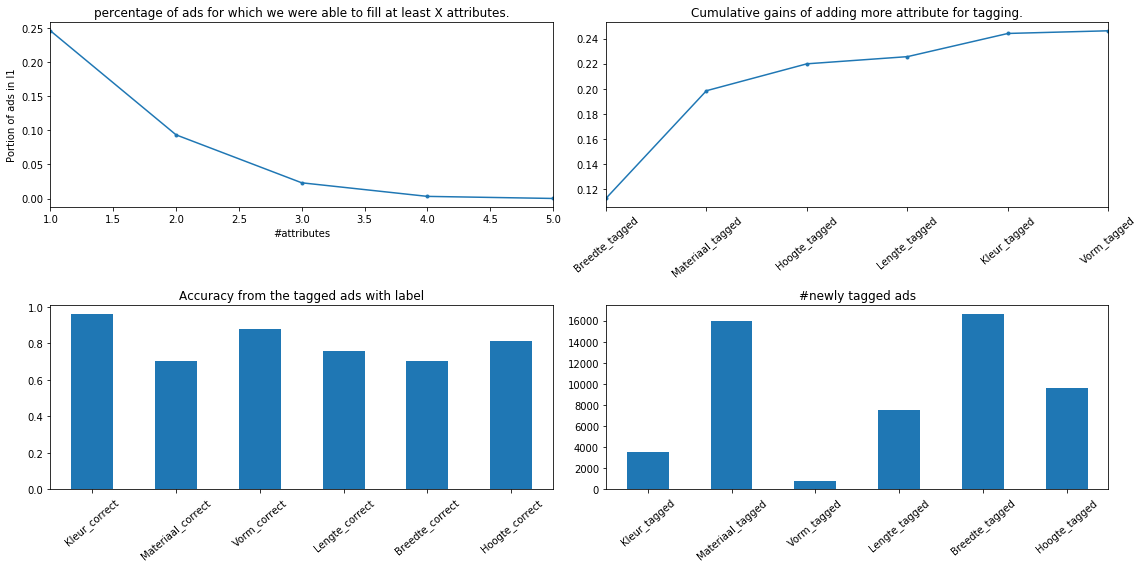

In [144]:
import seaborn as sns
tagged_cols = [attr+'_tagged' for attr in attrs]
flag_cols = [attr+'_correct' for attr in attrs]
tagged_cols = [attr+'_tagged' for attr in attrs]
df_data_l['n_tagged'] = df_data_l[tagged_cols].sum(axis = 1)
new_tags = df_data_l[tagged_cols].sum(axis=1).value_counts()/df_l1.index.nunique()
new_tags = new_tags.sort_values(ascending = True)
new_tags = new_tags[new_tags.index>0]
new_tags_cumsum = new_tags.cumsum()
tags_sum = df_data_l[tagged_cols].sum(axis=0)
tags_sum = tags_sum.sort_values(ascending = False)
ids = []
x = []
for idx in tags_sum.index:
    ids = set(ids).union(set(df_data_l[df_data_l[idx]==True].index.tolist()))
    x.append(len(ids))
x = pd.Series(x)
x.index = tags_sum.index
x = x/df_l1.index.nunique()
fig, axes = plt.subplots(2, 2,figsize = (16,8))
new_tags_cumsum.plot(kind = 'line', marker = '.', ax = axes[0, 0])
x.plot(kind = 'line', marker = '.', ax = axes[0, 1], rot = 40)
df_data_l[flag_cols].mean(axis=0).plot(kind = 'bar', ax = axes[1, 0], rot = 40)
df_data_l[tagged_cols].sum(axis=0).plot(kind = 'bar', ax = axes[1, 1], rot = 40)
axes[0, 0].set_xlabel('#attributes')
axes[0, 0].set_ylabel('Portion of ads in l1')
axes[0, 0].set_title('percentage of ads for which we were able to fill at least X attributes.')
axes[0, 1].set_title('Cumulative gains of adding more attribute for tagging.')
axes[1, 1].set_title('#newly tagged ads')
axes[1, 0].set_title('Accuracy from the tagged ads with label')
fig.tight_layout()
plt.show()

In [91]:
tagger.tag('Kleur : cognac, oranje/rood*', 'Stoelen')

{'Materiaal': [], 'Kleur': ['Oranje', 'Rood']}

# Unmatched

In [95]:
attr = 'Breedte'
flag_col = attr+'_correct'
label_col = attr+'_label'
df_data_l[df_data_l[flag_col]==False][['discription', 'title', label_col, 'l2', attr]].sample(10)

,discription,title,Breedte_label,l2,Breedte
ad_id,,,,,
1603938167,"Deze bank gaat in de verkoop omdat we een nieuwe bank hebben gekocht die beter in het huis past. De bank is uit 2017 en heeft een garantie op vlekken lopen tot 2022, hier kunnen we een certificaat van geven. \r\n\r\nDe hoek is te verplaatsen naar de andere kant.\r\n\r\nAfmetingen:\r\n\r\nbxhxd 242x82 cm\r\nZitdiepte 56 cm\r\nZithoogte 44 cm\r\n\r\nDe bank moet met spoed weg daar de nieuwe 1 oktober wordt geleverd.",Hoekbank Reuver,200 tot 250 cm,Banken | Bankstellen,[Minder dan 150 cm]
1604148861,Stoffen bankje in de kleur beige.\n\nDe “vlekken” die zichtbaar zijn is van de stoomreiniger. Het bankje is netjes gereinigd.\n\nAfmeting: 188x90x76\nZitdiepte 56 cm\nZithoogte 43 cm\n\nHet bankje verkeert in een nette gebruikte staat.,Stoffen bankje beige,150 tot 200 cm,Banken | Sofa's en Chaises Longues,[Minder dan 150 cm]
1603441773,Wegens verhuizing liefst bellen,Tafel met 2 banken,200 tot 250 cm,Banken | Bankstellen,[Minder dan 150 cm]
1604033955,Hoekbank grijs stof 310 x 170 cm slechts 2 jaar oud!!!!!\n\nZithoogte 48 cm\nHoogte rugleuning 52 cm\nBreedte hoekstuk 105 cm,Hoekbank grijs stof 310 x 170 cm slechts 2 jaar oud!!!!,300 cm of meer,Banken | Bankstellen,[150 tot 200 cm]
1604370664,Hoekbank met ottomaan. \nAfmeting 260x240cm. \nBestaat uit 2 delen welke met koppelstukken vast te zetten zijn en goed vast blijven zitten. \n\nStof ranche beige (mooie warme tint).\nZitten wel wat vlekjes en lichte penstrepen op de zitkussens. Het zijn losse hoezen dus eventueel zelf te reinigen. \n\nVoorkeur zelf ophalen eventueel leveren (tegen vergoeding) ook mogelijk.,Hoekbank 260x240cm stof ranche beige,250 tot 300 cm,Banken | Bankstellen,[200 tot 250 cm]
1604608090,"320 bij 270, moet woensdag opgehaald worden in het centrum in Rotterdam. Wordt op straat niveau geleverd dus scheelt trappen lopen ;)\nNeem bij interesse graag telefonisch contact op.\n4 jaar oud, amper gebruikt, nieuwprijs was 2800.",Bankstel uit gastverblijf te koop,300 cm of meer,Banken | Bankstellen,[250 tot 300 cm]
1603635674,Gebruikte keuken kastjes en granieten blad.\r\nDeurtjes zijn gekalkt eiken\r\nBlad 225x60 met spoelbakken en kraan\r\n1 onderkast 100 cm breed\r\n1 onderkast metladen 40 cm breed\r\n1 hoge kast 190x60 breed\r\n2 bovenkasten 100 x 50 x 32 met deuren met glas\r\n2 deuren 100x60,Keukenkasten en granieten blad,200 cm of meer,Keuken | Keukenelementen,"[50 tot 100 cm, 100 tot 150 cm, Minder dan 50 cm]"
1604311788,"Te koop\n\nNieuw tweepersoonsbed 1.60x2.00m\n\nWit metalen frame en houten lattenbodem\n\nincl matras (binnenvering)\n\nIs als logeerbed bedoeld geweest alleen nooit gebruikt.\n\nNieuwprijs:\nMatras €139,-\nBed & Lattenbodems €199,-\nSamen € 338,-\n\nVraagprijs € 250,-\n\nEnkel ophalen",Nieuw tweepersoonsbed 1.60x2.00m te koop,160 cm,Slaapkamer | Bedden,[70 cm of minder]
1603805820,"Een mooi antarciet bankstel bestaand uit 4 elementen (incl hocker) en 5 kussen te koop aangeboden.\r\n\r\nIk heb veel plezier gehad van dit bankstel, maar nu een andere bank op het oog. De bank ziet er nog goed uit en zit prima. Geen verzakkingen of iets dergelijks.\r\n\r\nToffe aan deze bank is dat hij uit meerdere elementen bestaat en daardoor in verschillende opstelling te zetten is. Zie de foto's.\r\n\r\nDe bank is in augustus 2020 gereinigd met een professioneel reinigingsapparaat (factuur aanwezig). Hij kan er dus weer een poosje tegenaan. \r\n\r\nMaten:\r\nzitdiepte: 67 cm\r\nzithoogte: 40 cm\r\ntotale breedte: 2.75m\r\nHocker: 95cm bij 80 cm\r\n\r\nEerst bezichtingen? Dat kan! Bieden van 200 euro",Bank zoekt nieuwe eigenaar,250 tot 300 cm,Banken | Bankstellen,[Minder dan 150 cm]


# Color

In [415]:
extract('Van binnen en buiten loodgrijs geverfd kastje. Van oorsprong eikenhout.Voor in hal oid .\n4 bolpootjes'.lower())

van ADP
binnen ADP
en CCONJ
buiten ADP
loodgrijs PROPN
geverfd PROPN
kast NOUN
. SYM
van ADP
oorsprong NOUN
eikenhout.voor CCONJ
in ADP
hal NOUN
oid VERB
. SYM

 SPACE
4 NUM
bolpootje NOUN


{'Kleur': [], 'Materiaal': []}

In [385]:
import time
start = time.time()
extract('Vierdelige pannenset van Sola. De pannen hebben een diameter van resp. 16, 18 en 20 cm., de steelpan van 16 cm. De set verkeert in nauwelijk tot niet van nieuw te onderscheiden staat. Uitgevoerd in gematteerd rvs. ')
end = time.time()
print(end - start)

0.04099321365356445


In [449]:
extract('Uitgevoerd in gematteerd rvs. ')
extract('metalen vierkante voet 45 cm hoog')

{'Kleur': [], 'Materiaal': []}

In [557]:
roots = [token.lower() for token in value_s['Materiaal']]
roots = [token for token in roots if not 'of' in token ]
lemma_tbl = lemmatizer.lookups.get_table("lemma_exc", {})
sub_tbl = {}
for key, lemma in lemma_tbl.items():
    if lemma in roots:
        sub_tbl[key] = lemma
print(set(roots) - set(sub_tbl.values()))
sub_tbl

{'metaal', 'pvc', 'eikenhout', 'linnen', 'beton', 'chroom', 'glas', 'overige houtsoorten', 'hardsteen', 'hpl', 'verzilverd', 'katoen', 'piepschuim (tempex)', 'glaswol', 'hardhout', 'ijzer', 'porselein', 'brons', 'eiken', 'rubber', 'hout', 'hardschuim (pir)', 'riet', 'zink', 'teakhout', 'overige metalen', 'lood', 'steenwol', 'titanium', 'plastic', 'edelsteen', 'overig', 'natuursteen', 'marmer', 'rvs', 'kokos', 'overige materialen', 'graniet', 'mdf', 'betonplex', 'keramiek', 'goud', 'kristal', 'zilver', 'parel', 'wicker', 'multiplex', 'aardewerk', 'grind', 'platina', 'kersenhout', 'verguld', 'elastiek', 'papier', 'koper', 'wol', 'steigerhout', 'tin', 'gietijzer', 'kant', 'steen', 'leer', 'grenenhout', 'carbon', 'staal', 'aluminium', 'polyester'}


{}

In [547]:
lemmatizer('houten', 'noun')

['hout']

In [373]:
doc = nlp('Vierdelige pannenset van Sola. De pannen hebben een diameter van resp. 16, 18 en 20 cm., de steelpan van 16 cm. De set verkeert in nauwelijk tot niet van nieuw te onderscheiden staat. Uitgevoerd in gematteerd rvs. ')
[token.lemma_ for token in doc]

['manden', ' ', 'metaal/', 'hout/', '*', 'stof']

In [555]:
lemmatizer.lookups.get_table("lemma_exc", {})

Table([(12401032943472870168,
        {'aaneengeschakelde': ['aaneengeschakeld'],
         'aaneenschakelende': ['aaneenschakelend'],
         'aangebrande': ['aangebrand'],
         'aangedane': ['aangedaan'],
         'aangeklede': ['aangekleed'],
         'aangeleerde': ['aangeleerd'],
         'aangelegde': ['aangelegd'],
         'aangepaste': ['aangepast'],
         'aangetekende': ['aangetekend'],
         'aangeërfde': ['aangeërfd'],
         'aangrenzende': ['aangrenzend'],
         'aangrijpende': ['aangrijpend'],
         'aanhoudende': ['aanhoudend'],
         'aankomende': ['aankomend'],
         'aanliggende': ['aanliggend'],
         'aanmatigende': ['aanmatigend'],
         'aannemelijker': ['aannemelijk'],
         'aanpalende': ['aanpalend'],
         'aanstaande': ['aanstaand'],
         'aanstotende': ['aanstotend'],
         'aanvallende': ['aanvallend'],
         'aanverwante': ['aanverwant'],
         'aanvoegende': ['aanvoegend'],
         'aanvullende': ['aanvu

In [552]:
lemmatizer.lookups.get_table("lemma_rules", {}).keys()

odict_keys([12401032943472870168, 16833663260455505849, 6360137228241296794, 431, 445, 10054248821341768113])